<a href="https://colab.research.google.com/github/mahinuralam/notebooks/blob/main/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the input shape and number of classes (Make sure to use the same values as in the training)
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset
# Adjust the batch size, learning rate, and augmentation parameters
batch_size = 32
learning_rate = 0.0001


# Define the path to the Downloads folder
train_data_dir = os.path.expanduser('~/Downloads/train/labeled_dataset_loco')

# Create data generators for training and validation with augmentation
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4
)

train_generator = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='sparse',  # Update class_mode to 'sparse'
    subset='training'
)

val_generator = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='sparse',  # Update class_mode to 'sparse'
    subset='validation'
)

# Define the path to the labeled dataset directory
test_data_dir = os.path.expanduser('~/Downloads/test/labeled_dataset_loco')  # Update this with the path to your labeled dataset

# Create a data generator for testing
test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' for numerical class labels
    shuffle=False,
)


2024-06-02 20:26:43.114021: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 20:26:43.163828: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-02 20:26:44.045806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 1562 images belonging to 5 classes.
Found 1039 images belonging to 5 classes.
Found 2601 images belonging to 5 classes.


AttributeError: Exception encountered when calling Average.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Average.call():
  • args=([['<KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_20247>'], ['<KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_20248>'], ['<KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_20249>'], ['<KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_20250>'], ['<KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_20251>'], ['<KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_20252>']],)
  • kwargs=<class 'inspect._empty'>

In [ ]:
import os
print(os.getcwd())


/home/mahin/Documents/notebook/Anomaly


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.16.1


ValueError: A total of 1 objects could not be loaded. Example error message for object <Dense name=predictions, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(1024, 1000), Received: value.shape=(50176, 128). Target variable: <KerasVariable shape=(1024, 1000), dtype=float32, path=predictions/kernel>

List of objects that could not be loaded:
[<Dense name=predictions, built=True>]

In [ ]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout


# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Create the Xception model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Change activation to 'softmax'
ResNet50 = Model(inputs=base_model.input, outputs=predictions)

# Adjust the batch size, learning rate, and augmentation parameters
batch_size = 32
learning_rate = 0.0001

# Compile the model
ResNet50.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# model.summary()


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Create checkpoint callback
checkpoint_path = 'checkpoint/ResNet50.weights.h5'
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)




# Train the model
history1 = ResNet50.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=35
)

2024-06-02 20:27:01.871618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-06-02 20:27:01.872190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22377 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


Epoch 1/35


/home/mahin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1717327658.955924 4058303 service.cc:145] XLA service 0x7892ec016180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717327658.955955 4058303 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1717327658.955957 4058303 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-02 20:27:40.028967: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2

 1/48 ━━━━━━━━━━━━━━━━━━━━ 49:24 63s/step - accuracy: 0.2692 - loss: 1.6109

I0000 00:00:1717327687.947055 4058303 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 2/48 ━━━━━━━━━━━━━━━━━━━━ 21:41 28s/step - accuracy: 0.2553 - loss: 1.6446

I0000 00:00:1717327716.175667 4058304 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 4 bytes spill stores, 4 bytes spill loads



48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5305 - loss: 1.1756

I0000 00:00:1717327756.467993 4061852 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1696', 184 bytes spill stores, 524 bytes spill loads



48/48 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.5334 - loss: 1.1692 - val_accuracy: 0.2891 - val_loss: 2.5289
Epoch 2/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.8438 - loss: 0.6725

2024-06-02 20:30:15.304734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:30:15.304945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/mahin/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8438 - loss: 0.6725 - val_accuracy: 0.5333 - val_loss: 1.5653
Epoch 3/35


2024-06-02 20:30:18.984914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:30:18.984965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8225 - loss: 0.4943 - val_accuracy: 0.2930 - val_loss: 1.9356
Epoch 4/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8438 - loss: 0.5338

2024-06-02 20:31:58.768871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:31:58.769021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8438 - loss: 0.5338 - val_accuracy: 0.2667 - val_loss: 2.0518
Epoch 5/35


2024-06-02 20:31:59.561139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:31:59.561187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8448 - loss: 0.4479 - val_accuracy: 0.2939 - val_loss: 2.2741
Epoch 6/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9062 - loss: 0.3100

2024-06-02 20:33:39.332962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:33:39.333303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9062 - loss: 0.3100 - val_accuracy: 0.2000 - val_loss: 2.6390
Epoch 7/35


2024-06-02 20:33:40.183677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:33:40.183720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8420 - loss: 0.4248 - val_accuracy: 0.2930 - val_loss: 1.9434
Epoch 8/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8438 - loss: 0.5227

2024-06-02 20:35:19.816198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:35:19.816501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8438 - loss: 0.5227 - val_accuracy: 0.2667 - val_loss: 2.0167
Epoch 9/35


2024-06-02 20:35:20.697760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:35:20.697919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8702 - loss: 0.3633 - val_accuracy: 0.2910 - val_loss: 1.6904
Epoch 10/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.8438 - loss: 0.3619

2024-06-02 20:37:00.578314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:37:00.578745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8438 - loss: 0.3619 - val_accuracy: 0.4000 - val_loss: 1.5296
Epoch 11/35


2024-06-02 20:37:01.370059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:37:01.370880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8817 - loss: 0.3338 - val_accuracy: 0.2939 - val_loss: 1.9672
Epoch 12/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9062 - loss: 0.5294

2024-06-02 20:38:41.279210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:38:41.279263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 20:38:41.279288: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 20:38:41.279373: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9062 - loss: 0.5294 - val_accuracy: 0.2000 - val_loss: 2.1234
Epoch 13/35


2024-06-02 20:38:42.154784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:38:42.154909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8783 - loss: 0.3402 - val_accuracy: 0.2949 - val_loss: 1.6472
Epoch 14/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.7812 - loss: 0.3877

2024-06-02 20:40:22.075557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:40:22.075869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7812 - loss: 0.3877 - val_accuracy: 0.1333 - val_loss: 1.8578
Epoch 15/35


2024-06-02 20:40:22.876451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:40:22.876490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8803 - loss: 0.3406 - val_accuracy: 0.2939 - val_loss: 2.0451
Epoch 16/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9062 - loss: 0.2128

2024-06-02 20:42:44.483666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:42:44.483807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9062 - loss: 0.2128 - val_accuracy: 0.2000 - val_loss: 2.2856
Epoch 17/35


2024-06-02 20:42:45.274266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:42:45.274353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8935 - loss: 0.3330 - val_accuracy: 0.2930 - val_loss: 1.6208
Epoch 18/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9375 - loss: 0.1822

2024-06-02 20:44:25.150084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:44:25.150547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9375 - loss: 0.1822 - val_accuracy: 0.3333 - val_loss: 1.5053
Epoch 19/35


2024-06-02 20:44:26.022174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:44:26.022222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9129 - loss: 0.2524 - val_accuracy: 0.3018 - val_loss: 1.6423
Epoch 20/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8750 - loss: 0.4332

2024-06-02 20:46:05.718345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:46:05.718562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8750 - loss: 0.4332 - val_accuracy: 0.2667 - val_loss: 1.5800
Epoch 21/35


2024-06-02 20:46:06.630206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:46:06.630242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8948 - loss: 0.3191 - val_accuracy: 0.4072 - val_loss: 1.4349
Epoch 22/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9062 - loss: 0.2582

2024-06-02 20:47:46.435477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:47:46.435677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9062 - loss: 0.2582 - val_accuracy: 0.2667 - val_loss: 1.4963
Epoch 23/35


2024-06-02 20:47:47.233166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:47:47.233218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9161 - loss: 0.2514 - val_accuracy: 0.5303 - val_loss: 1.2354
Epoch 24/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9375 - loss: 0.2369

2024-06-02 20:49:27.019258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:49:27.019345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9375 - loss: 0.2369 - val_accuracy: 0.6000 - val_loss: 1.1601
Epoch 25/35


2024-06-02 20:49:27.824944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:49:27.824982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 20:49:27.824996: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 20:49:27.825002: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9122 - loss: 0.2704 - val_accuracy: 0.7930 - val_loss: 0.7373
Epoch 26/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9375 - loss: 0.2878

2024-06-02 20:51:07.626172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:51:07.626615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9375 - loss: 0.2878 - val_accuracy: 0.9333 - val_loss: 0.5069
Epoch 27/35


2024-06-02 20:51:08.413908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:51:08.413963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9160 - loss: 0.2629 - val_accuracy: 0.8447 - val_loss: 0.6402
Epoch 28/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9062 - loss: 0.2797

2024-06-02 20:52:48.283902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:52:48.284079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9062 - loss: 0.2797 - val_accuracy: 1.0000 - val_loss: 0.5825
Epoch 29/35


2024-06-02 20:52:49.042098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:52:49.042137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8988 - loss: 0.2608 - val_accuracy: 0.9287 - val_loss: 0.3841
Epoch 30/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9062 - loss: 0.1792

2024-06-02 20:54:29.819026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:54:29.819119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9062 - loss: 0.1792 - val_accuracy: 0.9333 - val_loss: 0.3679
Epoch 31/35


2024-06-02 20:54:30.706765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:54:30.706938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9026 - loss: 0.2880 - val_accuracy: 0.9873 - val_loss: 0.2270
Epoch 32/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9375 - loss: 0.2383

2024-06-02 20:56:10.911006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:56:10.911286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9375 - loss: 0.2383 - val_accuracy: 1.0000 - val_loss: 0.1270
Epoch 33/35


2024-06-02 20:56:11.738410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:56:11.738460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 20:56:11.738475: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 20:56:11.738481: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9091 - loss: 0.2756 - val_accuracy: 0.9980 - val_loss: 0.0818
Epoch 34/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9688 - loss: 0.1301

2024-06-02 20:57:51.438545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:57:51.438735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9688 - loss: 0.1301 - val_accuracy: 1.0000 - val_loss: 0.0724
Epoch 35/35


2024-06-02 20:57:52.296239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 20:57:52.296421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9135 - loss: 0.2469 - val_accuracy: 1.0000 - val_loss: 0.0228


In [ ]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout



# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Create the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Change activation to 'softmax'
VGG16 = Model(inputs=base_model.input, outputs=predictions)

# Adjust the batch size, learning rate, and augmentation parameters
batch_size = 32
learning_rate = 0.0001

# Compile the model
VGG16.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# model.summary()

# Train the model
history2 = VGG16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=35
)

Epoch 1/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.3779 - loss: 1.4037 - val_accuracy: 0.8955 - val_loss: 0.3708
Epoch 2/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.6250 - loss: 1.0344

2024-06-02 21:01:52.923284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:01:52.923350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.6250 - loss: 1.0344 - val_accuracy: 0.9333 - val_loss: 0.2761
Epoch 3/35


2024-06-02 21:01:56.156467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:01:56.156603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.6851 - loss: 0.8692 - val_accuracy: 0.9033 - val_loss: 0.4691
Epoch 4/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.7812 - loss: 0.7120

2024-06-02 21:03:36.114697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:03:36.114766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7812 - loss: 0.7120 - val_accuracy: 0.8000 - val_loss: 0.8434
Epoch 5/35


2024-06-02 21:03:36.985388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:03:36.985425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7978 - loss: 0.6035 - val_accuracy: 0.9922 - val_loss: 0.0231
Epoch 6/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9375 - loss: 0.2750

2024-06-02 21:05:17.447888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:05:17.447955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9375 - loss: 0.2750 - val_accuracy: 0.9333 - val_loss: 0.0826
Epoch 7/35


2024-06-02 21:05:18.236973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:05:18.237013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-02 21:05:18.237043: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8445 - loss: 0.4806 - val_accuracy: 0.9834 - val_loss: 0.0500
Epoch 8/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9062 - loss: 0.2683

2024-06-02 21:06:58.023114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:06:58.023216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9062 - loss: 0.2683 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 9/35


2024-06-02 21:06:58.855888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:06:58.855928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8585 - loss: 0.4106 - val_accuracy: 1.0000 - val_loss: 3.0569e-04
Epoch 10/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9062 - loss: 0.2579

2024-06-02 21:08:38.654112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:08:38.654146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9062 - loss: 0.2579 - val_accuracy: 1.0000 - val_loss: 1.5495e-05
Epoch 11/35


2024-06-02 21:08:39.455301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:08:39.455347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8419 - loss: 0.4375 - val_accuracy: 1.0000 - val_loss: 3.7516e-04
Epoch 12/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.7812 - loss: 0.5512

2024-06-02 21:10:19.173525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:10:19.173604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7812 - loss: 0.5512 - val_accuracy: 1.0000 - val_loss: 4.0106e-05
Epoch 13/35


2024-06-02 21:10:19.994384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:10:19.994446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8689 - loss: 0.3944 - val_accuracy: 0.9971 - val_loss: 0.0094
Epoch 14/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.8750 - loss: 0.3755

2024-06-02 21:12:00.030962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:12:00.031012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 21:12:00.031027: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 21:12:00.031051: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8750 - loss: 0.3755 - val_accuracy: 1.0000 - val_loss: 2.0639e-04
Epoch 15/35


2024-06-02 21:12:00.873200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:12:00.873238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8657 - loss: 0.3647 - val_accuracy: 0.9922 - val_loss: 0.0156
Epoch 16/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8750 - loss: 0.3358

2024-06-02 21:13:40.792801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:13:40.792936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8750 - loss: 0.3358 - val_accuracy: 1.0000 - val_loss: 0.0355
Epoch 17/35


2024-06-02 21:13:41.537833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:13:41.537880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8721 - loss: 0.3639 - val_accuracy: 0.9961 - val_loss: 0.0077
Epoch 18/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8125 - loss: 0.3931

2024-06-02 21:15:21.229922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:15:21.230104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 21:15:22.087764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:15:22.087811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.8125 - loss: 0.3931 - val_accuracy: 1.0000 - val_loss: 4.7127e-06
Epoch 19/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8903 - loss: 0.3216 - val_accuracy: 1.0000 - val_loss: 4.8343e-04
Epoch 20/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8438 - loss: 0.3545

2024-06-02 21:17:21.277100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:17:21.277218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8438 - loss: 0.3545 - val_accuracy: 1.0000 - val_loss: 1.7007e-06
Epoch 21/35


2024-06-02 21:17:22.035534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-02 21:17:22.035568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:17:22.035592: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8908 - loss: 0.3342 - val_accuracy: 0.9863 - val_loss: 0.0411
Epoch 22/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9062 - loss: 0.3540

2024-06-02 21:19:01.611296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:19:01.611437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9062 - loss: 0.3540 - val_accuracy: 0.9333 - val_loss: 0.1942
Epoch 23/35


2024-06-02 21:19:02.437986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:19:02.438028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 21:19:02.438042: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 21:19:02.438055: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8879 - loss: 0.3106 - val_accuracy: 1.0000 - val_loss: 1.1272e-05
Epoch 24/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.8750 - loss: 0.4476

2024-06-02 21:20:42.200905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:20:42.200962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8750 - loss: 0.4476 - val_accuracy: 1.0000 - val_loss: 1.0570e-06
Epoch 25/35


2024-06-02 21:20:42.916127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:20:42.916162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8784 - loss: 0.3656 - val_accuracy: 0.9199 - val_loss: 0.4076
Epoch 26/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8750 - loss: 0.4369

2024-06-02 21:22:22.692540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:22:22.692648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8750 - loss: 0.4369 - val_accuracy: 0.9333 - val_loss: 0.6499
Epoch 27/35


2024-06-02 21:22:23.531733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:22:23.531780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8830 - loss: 0.3335 - val_accuracy: 0.9805 - val_loss: 0.0852
Epoch 28/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9062 - loss: 0.2629

2024-06-02 21:24:03.073822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:24:03.073933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9062 - loss: 0.2629 - val_accuracy: 1.0000 - val_loss: 1.9266e-04
Epoch 29/35


2024-06-02 21:24:03.882484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:24:03.882526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 21:24:03.882541: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 21:24:03.882558: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8957 - loss: 0.3098 - val_accuracy: 0.9990 - val_loss: 0.0023
Epoch 30/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9375 - loss: 0.2072

2024-06-02 21:25:43.404914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:25:43.404953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 21:25:43.404968: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 21:25:43.404982: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9375 - loss: 0.2072 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 31/35


2024-06-02 21:25:44.297951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:25:44.297989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9086 - loss: 0.2703 - val_accuracy: 1.0000 - val_loss: 5.4567e-05
Epoch 32/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9375 - loss: 0.2741

2024-06-02 21:27:24.130651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:27:24.130692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 21:27:24.130707: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 21:27:24.130722: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9375 - loss: 0.2741 - val_accuracy: 1.0000 - val_loss: 8.9009e-07
Epoch 33/35


2024-06-02 21:27:24.921720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:27:24.921804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9012 - loss: 0.2956 - val_accuracy: 1.0000 - val_loss: 2.9161e-04
Epoch 34/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.8125 - loss: 0.3814

2024-06-02 21:29:04.819535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:29:04.819597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8125 - loss: 0.3814 - val_accuracy: 1.0000 - val_loss: 4.5299e-07
Epoch 35/35


2024-06-02 21:29:05.643231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:29:05.643287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8983 - loss: 0.2889 - val_accuracy: 0.9912 - val_loss: 0.0183


In [ ]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout



# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Create the VGG16 model
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Change activation to 'softmax'
Xception = Model(inputs=base_model.input, outputs=predictions)

# Adjust the batch size, learning rate, and augmentation parameters
batch_size = 32
learning_rate = 0.0001

# Compile the model
Xception.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# model.summary()

# Train the model
history3 = Xception.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=35
)

Epoch 1/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.4108 - loss: 1.4238 - val_accuracy: 0.8926 - val_loss: 0.4572
Epoch 2/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.7500 - loss: 0.7773

2024-06-02 21:33:41.369746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:33:41.370864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.7500 - loss: 0.7773 - val_accuracy: 0.8667 - val_loss: 0.5375
Epoch 3/35


2024-06-02 21:33:45.227870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:33:45.227991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7474 - loss: 0.7020 - val_accuracy: 0.9033 - val_loss: 0.3167
Epoch 4/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.7812 - loss: 0.5097

2024-06-02 21:35:25.544945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:35:25.544988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 21:35:25.545013: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 21:35:25.545063: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7812 - loss: 0.5097 - val_accuracy: 0.8667 - val_loss: 0.3466
Epoch 5/35


2024-06-02 21:35:26.389448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:35:26.389507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8382 - loss: 0.4865 - val_accuracy: 0.9033 - val_loss: 0.2449
Epoch 6/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8750 - loss: 0.3103

2024-06-02 21:37:06.199044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:37:06.199522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8750 - loss: 0.3103 - val_accuracy: 0.8667 - val_loss: 0.3420
Epoch 7/35


2024-06-02 21:37:07.007498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:37:07.007560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 21:37:07.007588: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8422 - loss: 0.4649 - val_accuracy: 0.9062 - val_loss: 0.2195
Epoch 8/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8125 - loss: 0.6293

2024-06-02 21:38:46.974063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:38:46.974691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8125 - loss: 0.6293 - val_accuracy: 0.9333 - val_loss: 0.2438
Epoch 9/35


2024-06-02 21:38:47.754164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:38:47.754211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 21:38:47.754226: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 21:38:47.754232: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8683 - loss: 0.3818 - val_accuracy: 0.9199 - val_loss: 0.1622
Epoch 10/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8438 - loss: 0.4423

2024-06-02 21:40:27.726435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:40:27.727387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8438 - loss: 0.4423 - val_accuracy: 0.8000 - val_loss: 0.3456
Epoch 11/35


2024-06-02 21:40:28.565522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:40:28.565567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 21:40:28.565595: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8706 - loss: 0.3753 - val_accuracy: 0.9062 - val_loss: 0.2263
Epoch 12/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9062 - loss: 0.2430

2024-06-02 21:42:08.426381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:42:08.426914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9062 - loss: 0.2430 - val_accuracy: 1.0000 - val_loss: 0.0738
Epoch 13/35


2024-06-02 21:42:09.250083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:42:09.250219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9045 - loss: 0.3233 - val_accuracy: 0.9150 - val_loss: 0.2207
Epoch 14/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9231 - loss: 0.1952

2024-06-02 21:43:49.629136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:43:49.629632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9231 - loss: 0.1952 - val_accuracy: 0.8000 - val_loss: 0.6651
Epoch 15/35


2024-06-02 21:43:50.472526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:43:50.472568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8885 - loss: 0.3280 - val_accuracy: 0.9062 - val_loss: 0.6011
Epoch 16/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9062 - loss: 0.2167

2024-06-02 21:45:30.195471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:45:30.196129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9062 - loss: 0.2167 - val_accuracy: 0.6000 - val_loss: 2.4167
Epoch 17/35


2024-06-02 21:45:31.116391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:45:31.116511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8890 - loss: 0.3094 - val_accuracy: 0.9141 - val_loss: 0.2106
Epoch 18/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8750 - loss: 0.3834

2024-06-02 21:47:10.873746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:47:10.874637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8750 - loss: 0.3834 - val_accuracy: 0.8000 - val_loss: 0.4052
Epoch 19/35


2024-06-02 21:47:11.769239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:47:11.769283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 21:47:11.769296: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 21:47:11.769303: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9063 - loss: 0.2803 - val_accuracy: 0.9873 - val_loss: 0.0459
Epoch 20/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9375 - loss: 0.1553

2024-06-02 21:48:51.655239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:48:51.655713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9375 - loss: 0.1553 - val_accuracy: 1.0000 - val_loss: 0.0086
Epoch 21/35


2024-06-02 21:48:52.463129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:48:52.463294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9156 - loss: 0.2420 - val_accuracy: 0.9219 - val_loss: 0.2120
Epoch 22/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9375 - loss: 0.1949

2024-06-02 21:50:32.296129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:50:32.296894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9375 - loss: 0.1949 - val_accuracy: 0.8667 - val_loss: 0.2438
Epoch 23/35


2024-06-02 21:50:33.124059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:50:33.124113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 21:50:33.124128: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 21:50:33.124137: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8953 - loss: 0.3005 - val_accuracy: 0.9766 - val_loss: 0.0669
Epoch 24/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9062 - loss: 0.2620

2024-06-02 21:52:12.931529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:52:12.932216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9062 - loss: 0.2620 - val_accuracy: 1.0000 - val_loss: 1.5502e-04
Epoch 25/35


2024-06-02 21:52:13.705368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:52:13.705414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 21:52:13.705427: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 21:52:13.705448: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9077 - loss: 0.2372 - val_accuracy: 0.9062 - val_loss: 0.3729
Epoch 26/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8750 - loss: 0.2529

2024-06-02 21:53:53.749833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:53:53.750523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8750 - loss: 0.2529 - val_accuracy: 0.9333 - val_loss: 0.3712
Epoch 27/35


2024-06-02 21:53:54.556182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:53:54.556289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9004 - loss: 0.2538 - val_accuracy: 0.9570 - val_loss: 0.1040
Epoch 28/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.8750 - loss: 0.5143

2024-06-02 21:55:34.423493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:55:34.424467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8750 - loss: 0.5143 - val_accuracy: 0.8667 - val_loss: 0.1230
Epoch 29/35


2024-06-02 21:55:35.296626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:55:35.296665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9041 - loss: 0.2708 - val_accuracy: 0.9766 - val_loss: 0.0595
Epoch 30/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9375 - loss: 0.1630

2024-06-02 21:57:15.114386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:57:15.114852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9375 - loss: 0.1630 - val_accuracy: 1.0000 - val_loss: 5.3061e-05
Epoch 31/35


2024-06-02 21:57:15.902743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:57:15.902788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-02 21:57:15.902800: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9333 - loss: 0.2325 - val_accuracy: 0.9336 - val_loss: 0.2075
Epoch 32/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8750 - loss: 0.3677

2024-06-02 21:58:55.874245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:58:55.874954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8750 - loss: 0.3677 - val_accuracy: 0.8667 - val_loss: 0.6012
Epoch 33/35


2024-06-02 21:58:56.707840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 21:58:56.707879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9220 - loss: 0.2263 - val_accuracy: 0.9590 - val_loss: 0.1373
Epoch 34/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9375 - loss: 0.1804

2024-06-02 22:00:36.966981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:00:36.967724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9375 - loss: 0.1804 - val_accuracy: 0.8667 - val_loss: 0.1725
Epoch 35/35


2024-06-02 22:00:37.815097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:00:37.815237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9228 - loss: 0.2177 - val_accuracy: 0.9639 - val_loss: 0.0836


In [ ]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout



# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Create the VGG16 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Change activation to 'softmax'
InceptionV3 = Model(inputs=base_model.input, outputs=predictions)

# Adjust the batch size, learning rate, and augmentation parameters
batch_size = 32
learning_rate = 0.0001

# Compile the model
InceptionV3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# model.summary()

# Train the model
history4 = InceptionV3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=35
)

Epoch 1/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.4409 - loss: 1.3567 - val_accuracy: 0.9062 - val_loss: 0.1869
Epoch 2/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6875 - loss: 0.7073

2024-06-02 22:06:03.186200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:06:03.186355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6875 - loss: 0.7073 - val_accuracy: 0.9333 - val_loss: 0.1728
Epoch 3/35


2024-06-02 22:06:09.112449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:06:09.112945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7987 - loss: 0.6017 - val_accuracy: 0.9619 - val_loss: 0.0760
Epoch 4/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8125 - loss: 0.5684

2024-06-02 22:07:48.733193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:07:48.733513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8125 - loss: 0.5684 - val_accuracy: 0.8000 - val_loss: 0.3358
Epoch 5/35


2024-06-02 22:07:49.581058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:07:49.581492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8475 - loss: 0.4926 - val_accuracy: 0.9521 - val_loss: 0.1021
Epoch 6/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8438 - loss: 0.4313

2024-06-02 22:09:29.153940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:09:29.154345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8438 - loss: 0.4313 - val_accuracy: 0.9333 - val_loss: 0.0735
Epoch 7/35


2024-06-02 22:09:30.028251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:09:30.028938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8724 - loss: 0.4017 - val_accuracy: 0.9990 - val_loss: 0.0054
Epoch 8/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8750 - loss: 0.3993

2024-06-02 22:11:09.552626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:11:09.552996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8750 - loss: 0.3993 - val_accuracy: 1.0000 - val_loss: 9.2281e-04
Epoch 9/35


2024-06-02 22:11:10.398333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:11:10.398770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8693 - loss: 0.3887 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 10/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8750 - loss: 0.3400

2024-06-02 22:12:49.999188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:12:49.999526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 22:12:50.790235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:12:50.790479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.8750 - loss: 0.3400 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 11/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8802 - loss: 0.3573 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 12/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8125 - loss: 0.5501

2024-06-02 22:14:49.940165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:14:49.940525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8125 - loss: 0.5501 - val_accuracy: 1.0000 - val_loss: 0.0074
Epoch 13/35


2024-06-02 22:14:50.866328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:14:50.866831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8694 - loss: 0.3662 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 14/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7692 - loss: 0.7167

2024-06-02 22:16:30.329453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:16:30.329508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7692 - loss: 0.7167 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 15/35


2024-06-02 22:16:31.146572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:16:31.146923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8813 - loss: 0.3539 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 16/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7812 - loss: 0.5527

2024-06-02 22:18:10.618203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:18:10.618572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7812 - loss: 0.5527 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 17/35


2024-06-02 22:18:11.492711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:18:11.493165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8614 - loss: 0.3966 - val_accuracy: 1.0000 - val_loss: 2.4297e-04
Epoch 18/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9375 - loss: 0.2653

2024-06-02 22:19:51.383871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:19:51.384248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9375 - loss: 0.2653 - val_accuracy: 1.0000 - val_loss: 2.7658e-04
Epoch 19/35


2024-06-02 22:19:52.254437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:19:52.254836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8954 - loss: 0.3230 - val_accuracy: 1.0000 - val_loss: 2.3917e-04
Epoch 20/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8438 - loss: 0.4527

2024-06-02 22:22:13.151635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:22:13.151937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8438 - loss: 0.4527 - val_accuracy: 1.0000 - val_loss: 1.2409e-04
Epoch 21/35


2024-06-02 22:22:14.033984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:22:14.034407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9122 - loss: 0.2677 - val_accuracy: 1.0000 - val_loss: 2.6110e-04
Epoch 22/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8750 - loss: 0.3338

2024-06-02 22:23:53.412063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:23:53.412458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8750 - loss: 0.3338 - val_accuracy: 1.0000 - val_loss: 2.0177e-04
Epoch 23/35


2024-06-02 22:23:54.337308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:23:54.337605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9019 - loss: 0.3003 - val_accuracy: 1.0000 - val_loss: 5.7596e-04
Epoch 24/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8750 - loss: 0.3981

2024-06-02 22:25:33.933674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:25:33.934013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8750 - loss: 0.3981 - val_accuracy: 1.0000 - val_loss: 1.7105e-04
Epoch 25/35


2024-06-02 22:25:34.761499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:25:34.762106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8962 - loss: 0.3183 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 26/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9615 - loss: 0.1114

2024-06-02 22:27:14.492679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:27:14.492981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9615 - loss: 0.1114 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 27/35


2024-06-02 22:27:15.290213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:27:15.290812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9153 - loss: 0.2697 - val_accuracy: 1.0000 - val_loss: 5.5312e-05
Epoch 28/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9688 - loss: 0.1216

2024-06-02 22:28:54.844028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:28:54.844399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9688 - loss: 0.1216 - val_accuracy: 1.0000 - val_loss: 9.4568e-06
Epoch 29/35


2024-06-02 22:28:55.683991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:28:55.684379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9162 - loss: 0.2512 - val_accuracy: 1.0000 - val_loss: 1.5724e-04
Epoch 30/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9688 - loss: 0.1758

2024-06-02 22:30:35.915722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:30:35.916028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9688 - loss: 0.1758 - val_accuracy: 1.0000 - val_loss: 1.4774e-04
Epoch 31/35


2024-06-02 22:30:36.723087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:30:36.723380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9157 - loss: 0.2654 - val_accuracy: 1.0000 - val_loss: 5.8770e-04
Epoch 32/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8438 - loss: 0.3924

2024-06-02 22:32:16.178589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:32:16.178638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 22:32:16.178663: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 22:32:16.178671: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8438 - loss: 0.3924 - val_accuracy: 1.0000 - val_loss: 7.1095e-04
Epoch 33/35


2024-06-02 22:32:16.998151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:32:16.998737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9286 - loss: 0.2122 - val_accuracy: 1.0000 - val_loss: 5.5438e-04
Epoch 34/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9375 - loss: 0.1491

2024-06-02 22:33:56.450948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:33:56.451323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9375 - loss: 0.1491 - val_accuracy: 1.0000 - val_loss: 1.4893e-04
Epoch 35/35


2024-06-02 22:33:57.254519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:33:57.254857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9216 - loss: 0.2430 - val_accuracy: 1.0000 - val_loss: 1.2834e-04


In [ ]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout



# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Create the VGG16 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Change activation to 'softmax'
EfficientNetB0 = Model(inputs=base_model.input, outputs=predictions)

# Adjust the batch size, learning rate, and augmentation parameters
batch_size = 32
learning_rate = 0.0001

# Compile the model
EfficientNetB0.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# model.summary()

# Train the model
history4 = EfficientNetB0.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=35

)

Epoch 1/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2935 - loss: 1.5559

I0000 00:00:1717335574.902631   67779 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2048', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1717335574.949649   67782 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2048', 244 bytes spill stores, 244 bytes spill loads



48/48 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.2958 - loss: 1.5533 - val_accuracy: 0.1748 - val_loss: 1.6149
Epoch 2/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6250 - loss: 1.1047

2024-06-02 22:40:34.904261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:40:34.904343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
I0000 00:00:1717335636.907836   69266 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2048', 8 bytes spill stores, 8 bytes spill loads



48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.6250 - loss: 1.1047 - val_accuracy: 0.4000 - val_loss: 1.5588
Epoch 3/35


2024-06-02 22:40:40.818910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:40:40.818959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.6288 - loss: 1.0839 - val_accuracy: 0.4541 - val_loss: 1.5947
Epoch 4/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6250 - loss: 0.8199

2024-06-02 22:42:20.301624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:42:20.302174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6250 - loss: 0.8199 - val_accuracy: 0.4667 - val_loss: 1.5859
Epoch 5/35


2024-06-02 22:42:21.172404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:42:21.172467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7694 - loss: 0.7181 - val_accuracy: 0.1670 - val_loss: 1.6027
Epoch 6/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8750 - loss: 0.4983

2024-06-02 22:44:00.641347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:44:00.642181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8750 - loss: 0.4983 - val_accuracy: 0.1333 - val_loss: 1.6389
Epoch 7/35


2024-06-02 22:44:01.545028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:44:01.545081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 22:44:01.545107: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 22:44:01.545138: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8197 - loss: 0.5677 - val_accuracy: 0.1797 - val_loss: 1.5705
Epoch 8/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8750 - loss: 0.3673

2024-06-02 22:45:41.398702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:45:41.398953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8750 - loss: 0.3673 - val_accuracy: 0.1333 - val_loss: 1.5861
Epoch 9/35


2024-06-02 22:45:42.226928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:45:42.226969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8505 - loss: 0.4458 - val_accuracy: 0.1855 - val_loss: 1.5954
Epoch 10/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6875 - loss: 0.8662

2024-06-02 22:47:21.987732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:47:21.988627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6875 - loss: 0.8662 - val_accuracy: 0.1333 - val_loss: 1.6526
Epoch 11/35


2024-06-02 22:47:22.868690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:47:22.868741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8610 - loss: 0.3986 - val_accuracy: 0.1855 - val_loss: 1.5530
Epoch 12/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8438 - loss: 0.3792

2024-06-02 22:49:02.683097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:49:02.683410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8438 - loss: 0.3792 - val_accuracy: 0.1333 - val_loss: 1.6503
Epoch 13/35


2024-06-02 22:49:03.530865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:49:03.530914: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960
2024-06-02 22:49:03.530925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8384 - loss: 0.4379 - val_accuracy: 0.2432 - val_loss: 1.3638
Epoch 14/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9062 - loss: 0.1872

2024-06-02 22:50:43.148782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:50:43.149641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9062 - loss: 0.1872 - val_accuracy: 0.2667 - val_loss: 1.3836
Epoch 15/35


2024-06-02 22:50:43.931036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:50:43.931075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-02 22:50:43.931085: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8615 - loss: 0.4062 - val_accuracy: 0.5186 - val_loss: 1.0521
Epoch 16/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9062 - loss: 0.4031

2024-06-02 22:52:23.497578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:52:23.497992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9062 - loss: 0.4031 - val_accuracy: 0.6667 - val_loss: 0.9626
Epoch 17/35


2024-06-02 22:52:24.382818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:52:24.382862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-02 22:52:24.382874: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8598 - loss: 0.3955 - val_accuracy: 0.8936 - val_loss: 0.4631
Epoch 18/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9062 - loss: 0.2782

2024-06-02 22:54:04.116964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:54:04.117386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9062 - loss: 0.2782 - val_accuracy: 0.6667 - val_loss: 0.7062
Epoch 19/35


2024-06-02 22:54:05.047313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:54:05.047380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8862 - loss: 0.3487 - val_accuracy: 0.8936 - val_loss: 0.3193
Epoch 20/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8438 - loss: 0.5050

2024-06-02 22:55:44.183142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:55:44.184100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8438 - loss: 0.5050 - val_accuracy: 0.9333 - val_loss: 0.1976
Epoch 21/35


2024-06-02 22:55:44.923006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:55:44.923048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 22:55:44.923072: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8791 - loss: 0.3512 - val_accuracy: 0.9033 - val_loss: 0.2925
Epoch 22/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9375 - loss: 0.1682

2024-06-02 22:57:24.497104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:57:24.497859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9375 - loss: 0.1682 - val_accuracy: 0.9333 - val_loss: 0.2740
Epoch 23/35


2024-06-02 22:57:25.365090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:57:25.365124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8838 - loss: 0.3213 - val_accuracy: 0.9033 - val_loss: 0.2729
Epoch 24/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9688 - loss: 0.2137

2024-06-02 22:59:05.138741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:59:05.139521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9688 - loss: 0.2137 - val_accuracy: 0.9333 - val_loss: 0.1899
Epoch 25/35


2024-06-02 22:59:05.952686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 22:59:05.952724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8733 - loss: 0.3388 - val_accuracy: 0.9033 - val_loss: 0.2615
Epoch 26/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9062 - loss: 0.3387

2024-06-02 23:00:45.949664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:00:45.950592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 23:00:46.805527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:00:46.805616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 426ms/step - accuracy: 0.9062 - loss: 0.3387 - val_accuracy: 0.8667 - val_loss: 0.4306
Epoch 27/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8896 - loss: 0.3154 - val_accuracy: 0.9033 - val_loss: 0.2642
Epoch 28/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8750 - loss: 0.3947

2024-06-02 23:02:45.823274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:02:45.824079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8750 - loss: 0.3947 - val_accuracy: 0.8667 - val_loss: 0.4030
Epoch 29/35


2024-06-02 23:02:46.713175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:02:46.713235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 23:02:46.713365: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8860 - loss: 0.3365 - val_accuracy: 0.9033 - val_loss: 0.2651
Epoch 30/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9062 - loss: 0.3558

2024-06-02 23:04:26.567716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:04:26.567986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9062 - loss: 0.3558 - val_accuracy: 1.0000 - val_loss: 4.8571e-04
Epoch 31/35


2024-06-02 23:04:27.402330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:04:27.402375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-02 23:04:27.402389: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8916 - loss: 0.3132 - val_accuracy: 0.9102 - val_loss: 0.1882
Epoch 32/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8750 - loss: 0.3025

2024-06-02 23:06:07.054884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:06:07.055174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8750 - loss: 0.3025 - val_accuracy: 0.9333 - val_loss: 0.2131
Epoch 33/35


2024-06-02 23:06:07.924664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:06:07.924705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 23:06:07.924718: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5483928135940979114
2024-06-02 23:06:07.924724: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12117554537791547960


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8787 - loss: 0.3362 - val_accuracy: 0.9072 - val_loss: 0.2073
Epoch 34/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8438 - loss: 0.3395

2024-06-02 23:07:47.755579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:07:47.756395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8438 - loss: 0.3395 - val_accuracy: 1.0000 - val_loss: 3.3500e-04
Epoch 35/35


2024-06-02 23:07:48.562372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:07:48.562416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8909 - loss: 0.3156 - val_accuracy: 0.9414 - val_loss: 0.1064


In [ ]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout



# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5  # Update this line with the correct number of classes in your dataset

# Create the VGG16 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Change activation to 'softmax'
DenseNet121 = Model(inputs=base_model.input, outputs=predictions)

# Adjust the batch size, learning rate, and augmentation parameters
batch_size = 32
learning_rate = 0.0001

# Compile the model
DenseNet121.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# model.summary()

# Train the model
history6 = DenseNet121.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=35
)

Epoch 1/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4382 - loss: 1.3999

I0000 00:00:1717337669.062929  120676 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3290', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1717337669.388834  120669 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3290', 192 bytes spill stores, 192 bytes spill loads



48/48 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.4408 - loss: 1.3938 - val_accuracy: 0.9033 - val_loss: 0.5281
Epoch 2/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.6875 - loss: 0.7442

2024-06-02 23:15:30.552687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:15:30.553386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
I0000 00:00:1717337733.066282  122340 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3290', 344 bytes spill stores, 344 bytes spill loads



48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.6875 - loss: 0.7442 - val_accuracy: 0.8667 - val_loss: 0.5860
Epoch 3/35


2024-06-02 23:15:40.280703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:15:40.281184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7712 - loss: 0.6386 - val_accuracy: 0.9014 - val_loss: 0.4626
Epoch 4/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8750 - loss: 0.5264

2024-06-02 23:17:20.750884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:17:20.752183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8750 - loss: 0.5264 - val_accuracy: 1.0000 - val_loss: 0.0371
Epoch 5/35


2024-06-02 23:17:21.513646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:17:21.514250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8276 - loss: 0.5169 - val_accuracy: 0.9014 - val_loss: 0.4194
Epoch 6/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8125 - loss: 0.4166

2024-06-02 23:19:42.098388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:19:42.099245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8125 - loss: 0.4166 - val_accuracy: 1.0000 - val_loss: 0.0142
Epoch 7/35


2024-06-02 23:19:42.925399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:19:42.925958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8512 - loss: 0.4514 - val_accuracy: 0.9033 - val_loss: 0.3471
Epoch 8/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9375 - loss: 0.2746

2024-06-02 23:21:23.035817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:21:23.036932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9375 - loss: 0.2746 - val_accuracy: 0.8667 - val_loss: 0.4213
Epoch 9/35


2024-06-02 23:21:23.866991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:21:23.867473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8590 - loss: 0.3991 - val_accuracy: 0.9043 - val_loss: 0.4767
Epoch 10/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.7500 - loss: 0.6064

2024-06-02 23:23:04.422841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:23:04.424053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7500 - loss: 0.6064 - val_accuracy: 0.8000 - val_loss: 0.9889
Epoch 11/35


2024-06-02 23:23:05.213545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:23:05.214109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8781 - loss: 0.3655 - val_accuracy: 0.9600 - val_loss: 0.1084
Epoch 12/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8125 - loss: 0.3637

2024-06-02 23:24:45.111223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:24:45.112124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8125 - loss: 0.3637 - val_accuracy: 1.0000 - val_loss: 6.2363e-04
Epoch 13/35


2024-06-02 23:24:45.919130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:24:45.919679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8475 - loss: 0.4072 - val_accuracy: 0.9980 - val_loss: 0.0281
Epoch 14/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9062 - loss: 0.2810

2024-06-02 23:26:25.813729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:26:25.814819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9062 - loss: 0.2810 - val_accuracy: 1.0000 - val_loss: 0.0098
Epoch 15/35


2024-06-02 23:26:26.610134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:26:26.610728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8656 - loss: 0.3907 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 16/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8750 - loss: 0.2440

2024-06-02 23:28:06.290340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:28:06.291260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8750 - loss: 0.2440 - val_accuracy: 1.0000 - val_loss: 0.0084
Epoch 17/35


2024-06-02 23:28:07.132504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:28:07.133170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8809 - loss: 0.3483 - val_accuracy: 0.9883 - val_loss: 0.0313
Epoch 18/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8750 - loss: 0.3050

2024-06-02 23:29:47.266595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:29:47.267462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8750 - loss: 0.3050 - val_accuracy: 1.0000 - val_loss: 4.4766e-04
Epoch 19/35


2024-06-02 23:29:48.085266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:29:48.085620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9008 - loss: 0.3055 - val_accuracy: 0.9922 - val_loss: 0.0214
Epoch 20/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9062 - loss: 0.3633

2024-06-02 23:31:28.188750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:31:28.189729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 23:31:28.985264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:31:28.985543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 424ms/step - accuracy: 0.9062 - loss: 0.3633 - val_accuracy: 1.0000 - val_loss: 9.7138e-04
Epoch 21/35
48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8870 - loss: 0.3332 - val_accuracy: 0.9648 - val_loss: 0.0798
Epoch 22/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9062 - loss: 0.2519

2024-06-02 23:33:28.195241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:33:28.196829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9062 - loss: 0.2519 - val_accuracy: 0.9333 - val_loss: 0.1182
Epoch 23/35


2024-06-02 23:33:29.044710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:33:29.045365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9063 - loss: 0.2776 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 24/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9062 - loss: 0.2485

2024-06-02 23:35:09.069394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:35:09.069951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9062 - loss: 0.2485 - val_accuracy: 1.0000 - val_loss: 9.5834e-05
Epoch 25/35


2024-06-02 23:35:09.870605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:35:09.870982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8925 - loss: 0.2803 - val_accuracy: 0.9619 - val_loss: 0.0903
Epoch 26/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8438 - loss: 0.3734

2024-06-02 23:36:49.892228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:36:49.893003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8438 - loss: 0.3734 - val_accuracy: 0.9333 - val_loss: 0.1832
Epoch 27/35


2024-06-02 23:36:50.751528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:36:50.752053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9066 - loss: 0.2721 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 28/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8750 - loss: 0.3342

2024-06-02 23:39:11.469843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:39:11.471189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8750 - loss: 0.3342 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 29/35


2024-06-02 23:39:12.311826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:39:12.312429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8977 - loss: 0.2726 - val_accuracy: 0.9922 - val_loss: 0.0230
Epoch 30/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8750 - loss: 0.2646

2024-06-02 23:40:52.122085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:40:52.123651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8750 - loss: 0.2646 - val_accuracy: 1.0000 - val_loss: 0.0259
Epoch 31/35


2024-06-02 23:40:52.949873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:40:52.950532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9007 - loss: 0.2845 - val_accuracy: 1.0000 - val_loss: 0.0081
Epoch 32/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9062 - loss: 0.2274

2024-06-02 23:42:32.937068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:42:32.937825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9062 - loss: 0.2274 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 33/35


2024-06-02 23:42:33.769247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:42:33.769657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8981 - loss: 0.3036 - val_accuracy: 0.9971 - val_loss: 0.0076
Epoch 34/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9375 - loss: 0.1237

2024-06-02 23:44:13.801300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:44:13.802200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9375 - loss: 0.1237 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 35/35


2024-06-02 23:44:14.599833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 23:44:14.600328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9044 - loss: 0.2728 - val_accuracy: 1.0000 - val_loss: 0.0020


In [ ]:
from tensorflow.keras.layers import Input, Average


models = [ResNet50, VGG16, Xception, InceptionV3, EfficientNetB0, DenseNet121]

model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

ensemble_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=60,
        callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/35


I0000 00:00:1717340283.324766 4058303 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_287', 4 bytes spill stores, 4 bytes spill loads



48/48 ━━━━━━━━━━━━━━━━━━━━ 1381s 14s/step - accuracy: 0.9286 - loss: 0.2303 - val_accuracy: 0.9619 - val_loss: 0.0815
Epoch 2/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 22s 479ms/step - accuracy: 0.8438 - loss: 0.4480

2024-06-03 00:08:58.013790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:08:58.015769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 311ms/step - accuracy: 0.8438 - loss: 0.4480 - val_accuracy: 0.9333 - val_loss: 0.1264
Epoch 3/35


2024-06-03 00:09:12.545397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:09:12.548193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9215 - loss: 0.2406 - val_accuracy: 1.0000 - val_loss: 0.0595
Epoch 4/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 19s 424ms/step - accuracy: 0.8750 - loss: 0.3058

2024-06-03 00:10:55.380078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:10:55.383870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8750 - loss: 0.3058 - val_accuracy: 1.0000 - val_loss: 0.0352
Epoch 5/35


2024-06-03 00:10:55.876215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:10:55.879981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9271 - loss: 0.2231 - val_accuracy: 1.0000 - val_loss: 0.0279
Epoch 6/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - accuracy: 0.8750 - loss: 0.2480

2024-06-03 00:12:38.799679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:12:38.803334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8750 - loss: 0.2480 - val_accuracy: 1.0000 - val_loss: 0.0499
Epoch 7/35


2024-06-03 00:12:39.254795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:12:39.256749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9163 - loss: 0.2349 - val_accuracy: 0.9951 - val_loss: 0.0629
Epoch 8/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 19s 416ms/step - accuracy: 0.9375 - loss: 0.2390

2024-06-03 00:15:01.153467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:15:01.155408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9375 - loss: 0.2390 - val_accuracy: 1.0000 - val_loss: 0.0678
Epoch 9/35


2024-06-03 00:15:01.619161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:15:01.622088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9248 - loss: 0.2264 - val_accuracy: 1.0000 - val_loss: 0.0386
Epoch 10/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 19s 426ms/step - accuracy: 0.8438 - loss: 0.5826

2024-06-03 00:16:45.220831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:16:45.224778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8438 - loss: 0.5826 - val_accuracy: 1.0000 - val_loss: 0.0525
Epoch 11/35


2024-06-03 00:16:45.717626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:16:45.720732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9394 - loss: 0.2391 - val_accuracy: 0.9961 - val_loss: 0.0486
Epoch 12/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.9375 - loss: 0.2462

2024-06-03 00:18:28.374663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:18:28.376735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9375 - loss: 0.2462 - val_accuracy: 1.0000 - val_loss: 5.3510e-04
Epoch 13/35


2024-06-03 00:18:28.833768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:18:28.835859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9158 - loss: 0.2726 - val_accuracy: 1.0000 - val_loss: 0.0323
Epoch 14/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 19s 421ms/step - accuracy: 0.9062 - loss: 0.3127

2024-06-03 00:20:11.561916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:20:11.564519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9062 - loss: 0.3127 - val_accuracy: 1.0000 - val_loss: 0.0234
Epoch 15/35


2024-06-03 00:20:11.999239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:20:12.002309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9272 - loss: 0.2623 - val_accuracy: 1.0000 - val_loss: 0.0496
Epoch 16/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 17s 366ms/step - accuracy: 0.9231 - loss: 0.1938

2024-06-03 00:21:54.737600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:21:54.740450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9231 - loss: 0.1938 - val_accuracy: 1.0000 - val_loss: 0.0528
Epoch 17/35


2024-06-03 00:21:55.170421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:21:55.173985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9167 - loss: 0.2756 - val_accuracy: 0.9824 - val_loss: 0.0767
Epoch 18/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 19s 419ms/step - accuracy: 0.9375 - loss: 0.2277

2024-06-03 00:23:37.918032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:23:37.920777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9375 - loss: 0.2277 - val_accuracy: 0.9333 - val_loss: 0.1935
Epoch 19/35


2024-06-03 00:23:38.469853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:23:38.473334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9273 - loss: 0.2380 - val_accuracy: 0.9980 - val_loss: 0.0766
Epoch 20/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - accuracy: 0.9688 - loss: 0.2091

2024-06-03 00:25:21.402143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:25:21.406106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9688 - loss: 0.2091 - val_accuracy: 1.0000 - val_loss: 0.0502
Epoch 21/35


2024-06-03 00:25:21.839466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:25:21.842678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9236 - loss: 0.2468 - val_accuracy: 1.0000 - val_loss: 0.0535
Epoch 22/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 19s 422ms/step - accuracy: 0.8750 - loss: 0.3304

2024-06-03 00:27:04.648076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:27:04.651168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8750 - loss: 0.3304 - val_accuracy: 1.0000 - val_loss: 2.7815e-05
Epoch 23/35


2024-06-03 00:27:05.059339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:27:05.062894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9308 - loss: 0.2410 - val_accuracy: 0.9404 - val_loss: 0.1215
Epoch 24/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 19s 423ms/step - accuracy: 0.8438 - loss: 0.3387

2024-06-03 00:28:47.632608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:28:47.635705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8438 - loss: 0.3387 - val_accuracy: 0.9333 - val_loss: 0.1418
Epoch 25/35


2024-06-03 00:28:48.152437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:28:48.155136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9249 - loss: 0.2641 - val_accuracy: 1.0000 - val_loss: 0.0720
Epoch 26/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 19s 414ms/step - accuracy: 0.9062 - loss: 0.3116

2024-06-03 00:30:30.894834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:30:30.897262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9062 - loss: 0.3116 - val_accuracy: 1.0000 - val_loss: 0.0585
Epoch 27/35


2024-06-03 00:30:31.369809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:30:31.372947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9161 - loss: 0.2357 - val_accuracy: 0.9834 - val_loss: 0.1042
Epoch 28/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 19s 422ms/step - accuracy: 0.9062 - loss: 0.2237

2024-06-03 00:32:14.412760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:32:14.415449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9062 - loss: 0.2237 - val_accuracy: 1.0000 - val_loss: 0.0471
Epoch 29/35


2024-06-03 00:32:14.893768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:32:14.896353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9195 - loss: 0.2364 - val_accuracy: 0.9990 - val_loss: 0.0539
Epoch 30/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 19s 422ms/step - accuracy: 0.9062 - loss: 0.2258

2024-06-03 00:33:58.000723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:33:58.003454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9062 - loss: 0.2258 - val_accuracy: 1.0000 - val_loss: 0.0552
Epoch 31/35


2024-06-03 00:33:58.474432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:33:58.478588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9163 - loss: 0.2792 - val_accuracy: 0.9863 - val_loss: 0.0874
Epoch 32/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 19s 418ms/step - accuracy: 1.0000 - loss: 0.1098

2024-06-03 00:35:41.338611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:35:41.341318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.1098 - val_accuracy: 1.0000 - val_loss: 0.1100
Epoch 33/35


2024-06-03 00:35:41.854764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:35:41.856717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9345 - loss: 0.2294 - val_accuracy: 0.9834 - val_loss: 0.1036
Epoch 34/35
 1/48 ━━━━━━━━━━━━━━━━━━━━ 19s 421ms/step - accuracy: 0.9062 - loss: 0.2665

2024-06-03 00:37:28.546150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:37:28.548818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9062 - loss: 0.2665 - val_accuracy: 1.0000 - val_loss: 0.2089
Epoch 35/35


2024-06-03 00:37:29.058130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-03 00:37:29.062067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9146 - loss: 0.2465 - val_accuracy: 0.9971 - val_loss: 0.0615


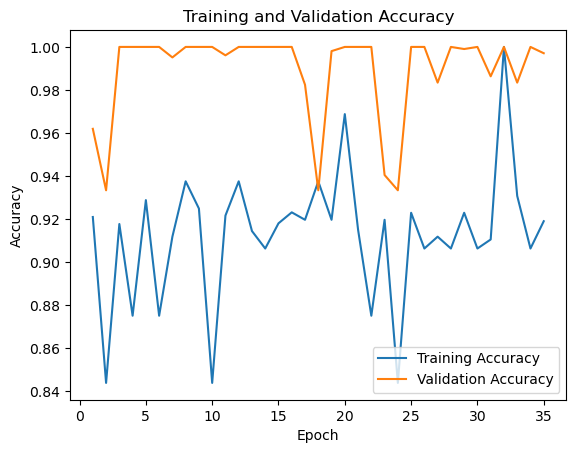

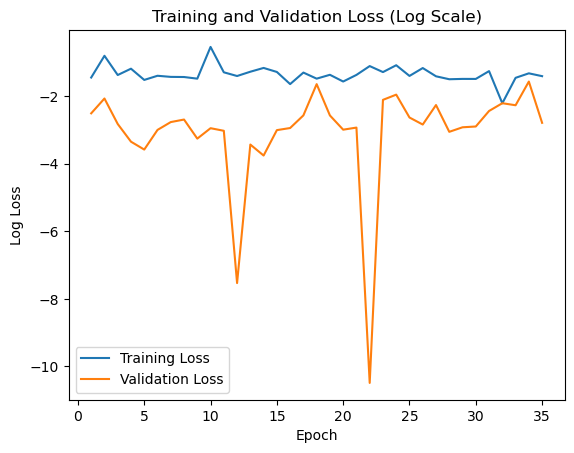

Best Validation Accuracy: 1.0000
Best Validation Loss: 0.0000


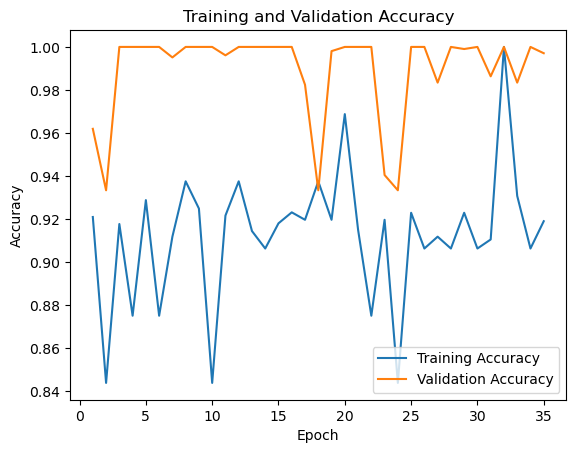

In [ ]:
# Plot the training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss using a logarithmic scale
plt.plot(range(1, len(train_loss) + 1), np.log(train_loss), label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), np.log(val_loss), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss (Log Scale)')
plt.legend()
plt.show()

# Create the accuracy plot
plt.figure()
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# Save the accuracy plot as an image
plt.savefig('accuracy_plot.png', bbox_inches='tight')

# Calculate and display the best validation accuracy and loss
best_val_accuracy = max(val_accuracy)
best_val_loss = min(val_loss)
print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')
print(f'Best Validation Loss: {best_val_loss:.4f}')

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Make predictions on the test data
true_labels = test_generator.classes
predictions = ensemble_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the anomaly percentage
total_images = len(true_labels)
anomaly_count = np.sum(predicted_labels != true_labels)
anomaly_percentage = (anomaly_count / total_images) * 100

# Print the anomaly percentage and accuracy
accuracy = (1 - (anomaly_count / total_images)) * 100
print(f'Accuracy: {accuracy:.2f}%')
print(f'Anomaly Percentage: {anomaly_percentage:.2f}%')


82/82 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step
Accuracy: 96.73%
Anomaly Percentage: 3.27%


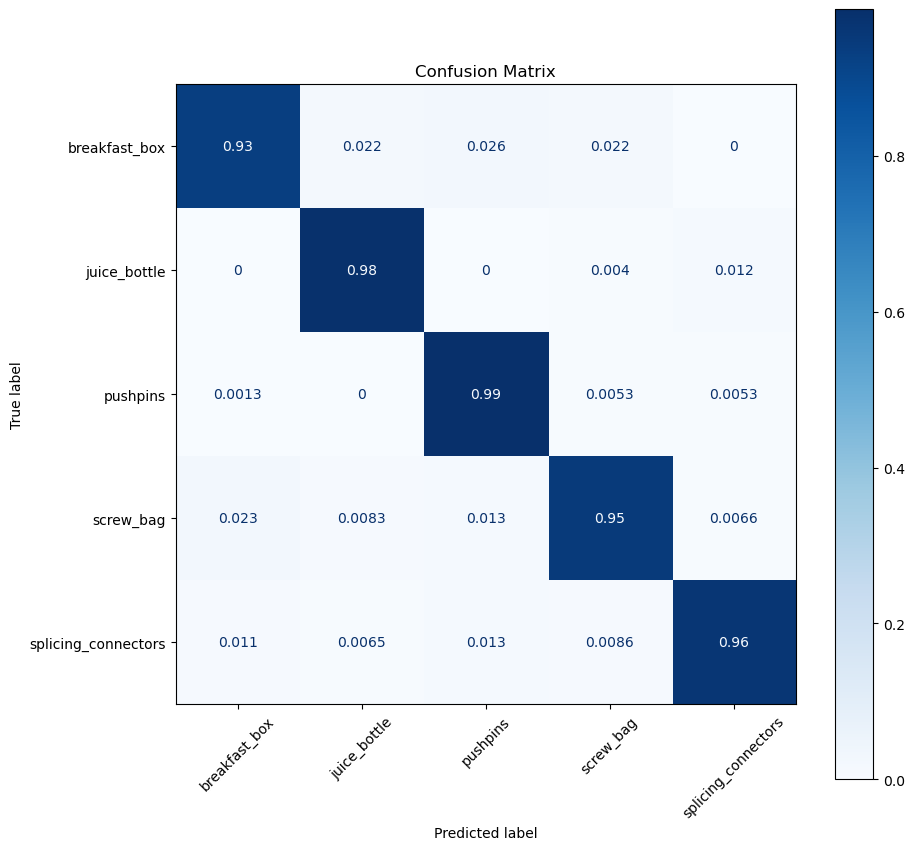

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# true_labels are the actual labels from your test data
# predicted_labels are the labels predicted by your model

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=45)  # Rotate labels to avoid overlap
plt.title('Confusion Matrix')
plt.show()
